In [1]:
import json
import base64
import numpy as np
import pandas as pd
import gzip
from tqdm.auto import tqdm
from datetime import datetime
from collections import OrderedDict

In [2]:
def p_date(x: str) -> datetime:
    """Short hand for datetime.fromisoformat(x)"""
    if isinstance(x, datetime):
        return  x
    return datetime.fromisoformat(x)

## Events log format
Each log object is a dictionary with multiple fields. The ones that are really important and used in this analysis are the following. Anything not docummented is not used for analyisis, and is probably an artifact of how SearchX treats the data, and can be safely ignored. (Feel free to explore, tough)
- `event`: Type of the event recorded. Related to clicks and hovers on parts and widgets of the SERP.
- `userId`: UniqueID of a user. On the user first interaction, this can be different to the final, due to the behaviour of Prolific user IDs.
- `sessionId`: User session ID. basically unused.
- `task`: JSON with the details of the user task, under `data` (Topics picked for the pre-test, topic picked with description and others):
    - `topics`: List with topics picked for the pre-test. `terms` are the terms used for the VKS test.
    - `scores`: VKS score on the pre-test for each topic
    - `topic`: Topic picked for the user
    - `subtopic` : List of subtopics for the user topic.
        - `terms`: Nested hierarchical outline for the topic (base64-formatted)
- `meta`: Data specific to the event type:
    - `url`: URL related to the event
    - `query`: User last issued query
    - `serpID`: Unique ID for this SERP
    - `session`: Type of experiment the user is currently on (control, qe(AQE_sc), visual(CURATED_sc) or progress(FEEDBACK_sc) )
    - `position`: Integer with the position of url (i.e. rank position)
- `date`: event timestamp

## Query log format
Each item in the `all_queries` object is a single submitted query
- `userId`: UniqueID of a user. On the user first interaction, this can be different to the final, due to the behaviour of Prolific user IDs.
- `sessionId`: User session ID. basically unused.
- `query`: User submitted query
- `created`: creation timestamp

In [3]:
with gzip.open("data/all_logs_clean.json.gz", 'r') as inf:
    all_logs = json.loads(inf.read().decode("utf-8"))
with gzip.open("data/all_queries_clean.json.gz", 'r') as inf:
    all_queries = json.loads(inf.read().decode("utf-8"))

vocab = json.load(open("data/vocab.json")) #VKS vocabulary dictionary
users = set([x["userId"] for x in all_logs])

## Pre_tests
Pre testes contains the information of the pre-tests from users (questions asked before user starts searching).

These questions are:
- degree: What is the highest degree completed?
    - 0: High School or lower
    - 1: Associate's degree(s) (e.g., AA AE, AFA, AS, ASN)
    - 2: Bachelor's degree(s) (e.g., BA, BBA, BFA, BS)
    - 3: Master's degree(s) (e.g., MA, MBA, MFA, MS, MSW)
    - 4: Specialist degree(s) (e.g., EdS)
    - 5: Applied or professional doctorate degree(s) (e.g., MD, DDC, DDS, JD, PharmD)
    - 6: Doctorate degree(s) (e.g., EdD, PhD)
    - 7: Other
- background_degree: For which subject areas do you have a \<degree answer\>?
- english: Are you an English native speaker?
- english-level: What is your level of English?
    - 0: Beginner
    - 1: Elementary
    - 2: Intermediate
    - 3: Upper-intermediate
    - 4: Advanced
    - 5: Proficiency
- web-previous: How often do you learn about a scientific topic (see the examples above) by searching the web?
- web-information-need: Think about the most recent time you learned about a scientific topic by searching the web. Describe what you were trying to learn.
- web-online: What are your preferred online resources (like Wikipedia, Coursera, Youtube etc.) to learn about a scientific topic?
- web-offline: What are your preferred offline resources (can be books, people, institutions) to learn about a scientific topic?

In [4]:
pre_tests = {
    **{
        x["sessionId"]: x["meta"]
        for x in all_logs if x['event'] == "SURVEY_REGISTER_RESULTS"
    },
    **{
        x["userId"]: x["meta"]
        for x in all_logs if x['event'] == "SURVEY_REGISTER_RESULTS"
    },
    **{
        x["meta"]["data"]["userId"]: x["meta"]
        for x in all_logs if x['event'] == "SURVEY_REGISTER_RESULTS"
    }
}

## Load data from Prolific
This data comes from Prolific system. We are just interested in their status, if they have returned (finished unsuccessfully) and so on.

In [5]:
prolific_path = [f"data/{x}" for x in ["prolific_export_5e4d0dea60c37d14cb329934.csv", "prolific_export_5e4e4f7be482212a2429a366.csv", "prolific_export_5f46799646aa3002de1afa25.csv"]]
prolific_last_time = dict()
session_length_prolific = dict()
prolific_status = dict()
prolific_users = set()
returned_code = dict()
found = 0
for p in prolific_path:
    for line in open(p):
        l = line.split(",")
        if l[0] == "session_id":
            continue
        participant_id = l[1] 
        prolific_users.add(participant_id)
        duration = float(l[5])
        status = l[2]
        returned_code[participant_id] = l[11]
        prolific_status[participant_id] = status
        prolific_last_time[participant_id] = l[4]
        session_length_prolific[participant_id] = duration

## Metrics
These functions compute specifict metrics for analysis. They may be inter-dependent.

### Learning Gain

In [6]:
def ALG(user_logs: list[dict], topic: str) -> float:
    """Computes Absolute Learning Gains:
    Args:
        user_logs: sorted (by time) list with all of one user's logs
        topic: string with user's topic id
    """
    score = 0
    topic_terms = get_topic_terms(topic)
    pretest_results = [
        r for r in user_logs if r["event"] == "SURVEY_PRE_TEST_RESULTS"
    ][0]
    posttest_results = [
        r for r in user_logs if r["event"] == "SURVEY_POST_TEST_RESULTS"
    ][0]
    score_mapping = {1: 0, 2: 0, 3: 1, 4: 2}
    for question in topic_terms:
        qid = "Q-" + str(topic) + "-" + str(question)
        pre_score = score_mapping[int(pretest_results["meta"]["data"][qid])]
        post_score = score_mapping[int(posttest_results["meta"]["data"][qid])]
        score += max(0, post_score - pre_score)
    return score / 10


def MLG(user_logs: list[dict], topic: str) -> float:
    """Computes Maximum possible learning potential
    Args:
        user_logs: sorted (by time) list with all of one user's logs
        topic: string with users' topic id
    """
    topic_terms = get_topic_terms(topic)
    pretest_results = [
        r for r in user_logs if r["event"] == "SURVEY_PRE_TEST_RESULTS"
    ][0]
    score = 0
    score_mapping = {1: 0, 2: 0, 3: 1, 4: 2}
    for question in topic_terms:
        qid = "Q-" + str(topic) + "-" + str(question)
        pre_score = score_mapping[int(pretest_results["meta"]["data"][qid])]
        score += 2 - pre_score
    return score / 10


def RPL(user_logs: list, topic: str) -> float:
    """Computes user's Realized Potential Learning:
    Args:
        user_logs: List of one user's logs
        topic: string with user's topic id 
    """
    sorted_logs = sorted(user_logs, key=lambda x: x["date"], reverse=True)
    _ALG = ALG(sorted_logs, topic)
    _MLG = MLG(sorted_logs, topic)
    return _ALG / _MLG

### Other metrics

In [7]:
def get_all_logs(user: str) -> list[dict]:
    """Get all logs from one user"""
    user_logs = [x for x in all_logs if x["userId"] == user]
    return user_logs


def get_topic_title(user_logs: list[dict]) -> str:
    """Gets the title of the topic assigned to user"""
    return [x for x in user_logs if x["event"] == "SURVEY_POST_TEST_RESULTS"
            ][0]['task']['data']['topic']['title']


def get_topic_id(user_logs: list[dict]) -> str:
    """Gets the id of the topic the user was assigned to"""
    for x in user_logs:
        if x["event"] == "SEARCHRESULT_VIEW_URL":
            return x["task"]["data"]["topic"]["id"]


def get_topic_terms(p: str) -> list[str]:
    """Gets a list of the terms for the VKS for a given topic id"""
    return vocab[p]["terms"]


def get_both_topics(user_log: list[dict]) -> list[str]:
    """Gets both topics assigned to user during pre-test"""
    return [
        x["title"] for x in [
            x for x in user_log if x["event"] == "SURVEY_PRE_TEST_RESULTS"
        ][0]["task"]["data"]["topics"] if x["title"] != "Sports"
    ]


def get_user_education(user_log):
    sessionId = user_log[0]["sessionId"]
    userId = user_log[0]["userId"]
    if userId in pre_tests:
        value = pre_tests[userId]["data"]["degree"]
        mapping = {
            0: "High School",
            1: "Associate's degree(s)",
            2: "Bachelor's degree(s)",
            3: "Master's degree(s)",
            4: "Specialist degree(s)",
            5: "Applied or professional doctorate degree(s)",
            6: "Doctorate degree",
            7: "Other"
        }
        return mapping[value]
    return "Unknown"


def get_queries(user: str) -> list[str]:
    """Get all queries a user submitted"""
    u_queries = [x["query"] for x in all_queries if x["userId"] == user]
    return u_queries


def get_session_duration(user_logs: list[dict]) -> int:
    """Gets how long, in seconds, a user session lasted, from start to end"""
    sorted_logs = sorted(user_logs, key=lambda x: x["date"], reverse=False)
    end_time = p_date(sorted_logs[-1]["date"])
    start_time = p_date(sorted_logs[0]["date"])
    return (end_time - start_time).seconds


def get_user_average_dwell_time(user_log: list[dict]) -> int:
    """Gets the user average dwell time in seconds (How long they spend one one document)"""
    documents_events = sorted([
        x
        for x in user_log if x["event"] in ["DOCUMENT_CLOSE", "DOCUMENT_LOAD"]
    ],
                              key=lambda x: x["date"],
                              reverse=False)
    urls = {x["meta"]["url"] for x in documents_events}
    dwell_times = []
    for url in urls:
        doc_events = [x for x in documents_events if x["meta"]["url"] == url]
        for i in range(0, len(doc_events), 2):
            if i + 1 == len(doc_events):
                continue
            if doc_events[i]["event"] == "DOCUMENT_LOAD" and doc_events[
                    i + 1]["event"] == "DOCUMENT_CLOSE":
                start_time = p_date(doc_events[i + 1]["date"])
                end_time = p_date(doc_events[i]["date"])
                dwell_times.append(start_time - end_time)
    if len(dwell_times) == 0:
        return 0
    return np.mean(dwell_times).seconds


def get_session(user_logs: list[dict]) -> str:
    """Get what type of experiment the user was in"""
    event = [x for x in user_logs if x["event"] == "SEARCHRESULT_VIEW_URL"][0]
    return event["meta"]["session"]


def get_views(user_logs: list[dict]) -> list[dict]:
    """Gets all snippets the user saw"""
    return [x for x in user_logs if x["event"] == "SEARCHRESULT_VIEW_URL"]


def get_clicks(user_logs: list[dict]) -> list[dict]:
    """Gets all document click events"""
    return [x for x in user_logs if x["event"] == "SEARCHRESULT_CLICK_URL"]


def get_unique_docs(user_clicks: list[dict]) -> list[dict]:
    """Gets all unique docs ther user clicked
    Args:
        user_clicks: List of all SEARCHRESULT_CLICK_URL events (call get_clicks() for this)
    """
    return len(set([x['meta']['url'] for x in user_clicks]))


def get_search_session_time(user_log: list[dict]) -> int:
    """Gets how long, in seconds, between first document open and last document close"""
    li = [x['event'] for x in user_log]
    for i in range(len(li)):
        if li[i] == "SEARCH_QUERY":
            index = i
            first_query_time = p_date(user_log[index]["date"])
            break
    #get last document_close
    for i in range(len(li) - 1, -1, -1):
        if li[i] == 'DOCUMENT_CLOSE':
            last_doc_close = p_date(user_log[i]["date"])
            break
    delta = last_doc_close - first_query_time
    return delta.seconds


def get_answer_changes(user_logs: list[dict]) -> tuple[int]:
    """Gets how many changes of user knowledge happenned on the post-test
    Args:
        user_logs: List with all user interactions
    Returns:
        one_to_four: Change from knowledge level 1 to 4
        one_to_three: Change from knowledge level 1 to 3
        three_to_four: Change from knowledge level 3 to 4
        one_remaining: Stayed on level 1 (no knowledge improvement)
        other: Other changes (knowledge decreased [??])
        valids: valids questions (sanity check)
    """
    topic = get_topic_id(user_logs)
    terms = get_topic_terms(topic)
    one_to_four = 0
    one_to_three = 0
    three_to_four = 0
    one_remaining = 0
    other = 0
    valids = 0
    for r in user_logs:
        if r["event"] == "SURVEY_PRE_TEST_RESULTS":
            pretest_results = r
            break
    for r in user_logs:
        if r["event"] == "SURVEY_POST_TEST_RESULTS":
            posttest_results = r
            break
    for question in terms:
        qid = "Q-" + str(topic) + "-" + str(question)
        pre = int(pretest_results["meta"]["data"][qid])
        post = int(posttest_results["meta"]["data"][qid])
        if (pre == 1 or pre == 2) and post == 4:
            one_to_four += 1
        elif (pre == 1 or pre == 2) and post == 3:
            one_to_three += 1
        elif pre == 3 and post == 4:
            three_to_four += 1
        elif (pre == 1 or pre == 2):
            one_remaining += 1
            valids -= 1
        else:
            other += 1
    return (one_to_four, one_to_three, three_to_four, one_remaining, other)


def get_average_query_term_coverage(user_queries: list[str],
                                    user_log: list[dict]) -> float:
    """Gets how many query terms, on average, the user used"""
    topic_terms = get_topic_subtopic_terms(user_log)
    user_queries_terms = [set(x.lower().split()) for x in user_queries]
    query_coverage = []
    for query in user_queries_terms:
        query_coverage.append(
            len(query.intersection(topic_terms)) / len(query))
    return np.mean(query_coverage)


def get_subtopics(user_log: list[dict]) -> str:
    """Gets all subtopics for a given user topic"""
    data = [x for x in user_log if x["event"] == "SURVEY_POST_TEST_RESULTS"
            ][0]["task"]["data"]['subtopic']["terms"]
    return base64.b64decode(data).decode("utf-8")


def get_subtopic_terms(user_log: list[dict]) -> list[str]:
    """Gets all terms for subtopics"""
    subtopics = [
        x for x in user_log if x["event"] == "SURVEY_POST_TEST_RESULTS"
    ][0]["task"]["data"]['subtopic']["terms"]
    return subtopics


def get_topic_subtopic_terms(user_log: list[dict]) -> set[str]:
    """Gets all topic and subtopic titles, and made then into a set"""
    subtopics = eval(get_subtopics(user_log))
    topic = get_topic_title(user_log)
    terms = " ".join(subtopics.keys()).lower().split()
    for i in subtopics.values():
        for j in i:
            terms += j.lower().split()
    return set(terms)


def get_number_of_bookmars(user_log: list[dict]) -> int:
    """`Gets how many bookmarks the user created"""
    return len([x for x in user_log if x["event"] == "BOOKMARK_ACTION"])

In [8]:
dataset = []

for count, user in tqdm(enumerate(users), total=len(users)):
    user_log = get_all_logs(user) # All user events

    user_queries = get_queries(user) # All user queries
    user_session = get_session(user_log) # What experiment the user was assigned to
    topic = get_topic_title(user_log) # User topic
    topic_id = get_topic_id(user_log) # User topic id
    education_level = get_user_education(user_log) # User education level
    
    session_duration_in_minutes = get_session_duration(user_log)//60 
    realized_learning_gain = RPL(user_log, topic_id)
    absolute_learning_gain = ALG(user_log, topic_id)
    user_url_views = get_views(user_log) # All snippets seen
    number_of_views = len(user_url_views) # Number of snippets seen

    user_url_clicks = get_clicks(user_log) # All documents clicked
    number_of_clicks = len(user_url_clicks) # Number of documents clicked
    unique_docs = get_unique_docs(user_url_clicks) # Number of unique documents clicked
    
    number_of_queries = len(user_queries) # Number of issued queries
    avg_query_len = np.mean([len(x.split()) for x in user_queries])

    search_time = get_search_session_time(user_log) # How long from first document open to last document close
    session_duration_in_minutes = get_session_duration(user_log) # How long from start to end of experiment
    average_dwell_time = get_user_average_dwell_time(user_log) # Average dwell time on document
    
    # In-depth analysis
    (one_to_four, one_to_three, three_to_four, one_remaining, other) = get_answer_changes(user_log) # Changes from one level to another on post-test
    query_term_coverage = get_average_query_term_coverage(user_queries, user_log) # Overlap between query terms and scaffolding terms

    number_of_bookmars = get_number_of_bookmars(user_log) # Number of bookmark events
    dataset.append({"user":user, 
                    "absolute_learning_gain": absolute_learning_gain, 
                    "realized_learning_gain": realized_learning_gain,
                    "type": user_session, 
                    "average_query_len":avg_query_len,
                    "number_of_queries": number_of_queries,
                    "number_of_views": number_of_views,
                    "number_of_clicks": number_of_clicks,
                    "session_duration":session_duration_in_minutes,
                    "one_two_to_four": one_to_four,
                    "one_two_to_three": one_to_three,
                    "three_to_four": three_to_four,
                    "one_two_no_change": one_remaining,
                    "other": other,
                    "topic": topic,
                    "average_dwell_time" : average_dwell_time,
                    "unique_docs" : unique_docs,
                    "number_of_bookmars": number_of_bookmars,
                    "education_level": education_level,
                    "search_time": search_time
                    })
df = pd.DataFrame(dataset)
print(df.shape)

  0%|          | 0/127 [00:00<?, ?it/s]

(127, 20)


## Plots
These are auxiliary functions to plot boxplots for the metrics computed above.

In [20]:
from scipy.stats import f_oneway, kruskal, ttest_ind, pearsonr
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
order = list(df.groupby("type", sort=False)["realized_learning_gain"].mean().index)
order

['progress', 'visual', 'control', 'qe']

P-Value control vs qe:		0.36835, Not singnificant
P-Value control vs visual:	0.23638, Not singnificant
P-Value control vs progress:	0.81375, Not singnificant
P-Value qe vs visual:		0.71019, Not singnificant
P-Value visual vs progress:	0.19322, Not singnificant


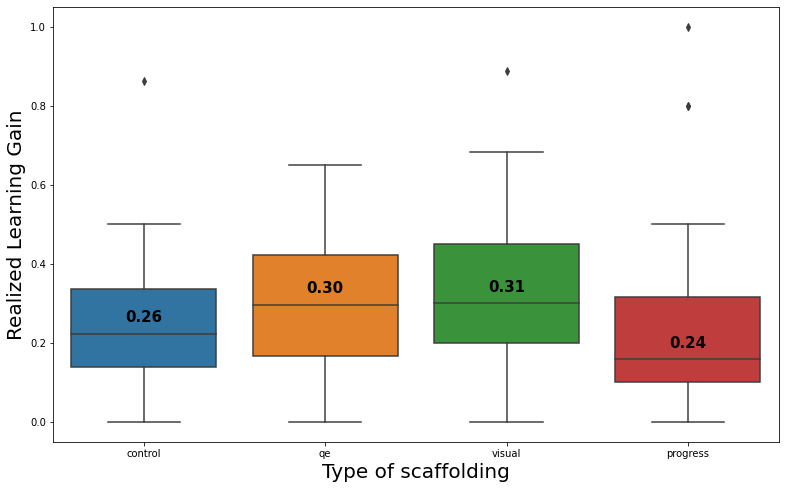

<Figure size 432x288 with 0 Axes>

In [32]:
def make_boxplot(df: pd.DataFrame, y:str):
    """Creates a boxplot from dataframe df, attribute y"""
    ylabel = y.replace("_", " ").title()
    figure(num=None, figsize=(13,8))
    order = ["control", "qe", "visual", "progress"]
    ax = sns.boxplot(data=df, x="type", y=y, order = order)

    means = df.groupby("type", sort=False)[y].mean()[order]
    medians = df.groupby("type", sort=False)[y].median()[order].values
    
    if "time" in y:
        nobs = [f"{means[_type]:.2f}s" for x, _type in zip(df["type"].value_counts()[order], order)]
    else:
        nobs = [f"{means[_type]:.2f}" for x, _type in zip(df["type"].value_counts()[order], order)]

    # Pair wise statistical tests
    for i, j in [("control", "qe"), ("control", "visual"), ("control", "progress"), ("qe", "visual"), ("visual", "progress")]:
        p_value = ttest_ind(df[df.type==i][y], df[df.type==j][y]).pvalue
        significant = "Significant" if p_value < 0.05 else "Not singnificant"
        if i == "qe" or j == "qe":  #Just to make everything aligned.
            print(f"p-Value {i} vs {j}:\t\t{p_value:.5f}, {significant}")
        else:
            print(f"p-Value {i} vs {j}:\t{p_value:.5f}, {significant}")

    pos = range(len(nobs))
    for tick, label in zip(pos, ax.get_xticklabels()):
        ax.text(pos[tick], medians[tick]+0.03, nobs[tick], horizontalalignment="center", color="black", weight="semibold", fontsize=15)
    ax.set_xlabel("Type of scaffolding", fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    plt.show()
    plt.clf()

make_boxplot(df, "realized_learning_gain")

